In [ ]:
import os
import pandas as pd
from langid import classify

import matplotlib.pyplot as plt
import re
from collections import Counter
import numpy as np

# Importing dataset

In [39]:
li = []
for filename in os.listdir("../challenge_data/train_tweets"):
    df = pd.read_csv("../challenge_data/train_tweets/" + filename)
    li.append(df)
df = pd.concat(li, ignore_index=True)

In [24]:
print(df.head())
print("\n")
print(df.shape)

    ID  MatchID  PeriodID  EventType      Timestamp  \
0  2_0        2         0          0  1403538600000   
1  2_0        2         0          0  1403538600000   
2  2_0        2         0          0  1403538600000   
3  2_0        2         0          0  1403538600000   
4  2_0        2         0          0  1403538600000   

                                               Tweet  Character_Count  
0  RT @soccerdotcom: If #ESP beats #AUS we'll giv...              140  
1  Visit the #SITEP official web site here http:/...              135  
2  RT @soccerdotcom: If #ESP beats #AUS we'll giv...              140  
3  RT @worldsoccershop: If there is a winner in t...              140  
4  RT @soccerdotcom: If #AUS beats #ESP we'll giv...              140  


(5056050, 7)


In [44]:
matches = {}
for filename in os.listdir("../challenge_data/train_tweets"):
    df_ = pd.read_csv("../challenge_data/train_tweets/" + filename)["MatchID"]
    match_id = df_.iloc[0]
    matches[match_id] = filename[:-6]

print(matches)

{2: 'AustraliaSpain', 3: 'PortugalGhana', 8: 'CameroonBrazil', 1: 'GermanyBrazil', 14: 'BelgiumSouthKorea', 7: 'NetherlandsChile', 4: 'GermanyAlgeria', 5: 'FranceGermany', 19: 'MexicoCroatia', 13: 'FranceNigeria', 12: 'AustraliaNetherlands', 0: 'HondurasSwitzerland', 10: 'ArgentinaGermanyFinal', 11: 'ArgentinaBelgium', 18: 'USASlovenia20', 17: 'GermanyUSA'}


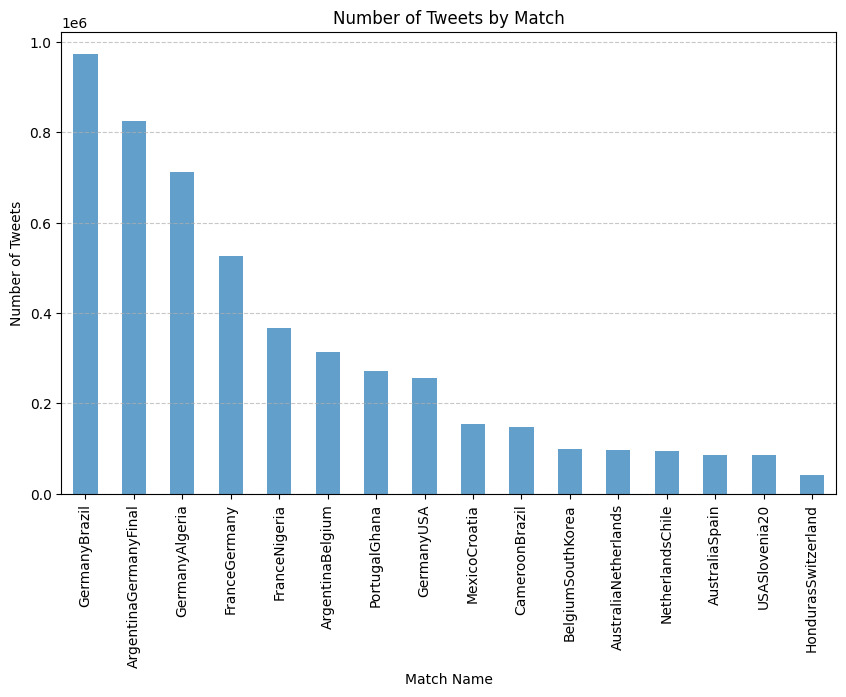

In [45]:
# Plot histogram of the number of tweets by match
plt.figure(figsize=(10, 6))
df['MatchID'].map(matches).value_counts().plot(kind='bar', alpha=0.7)
plt.title("Number of Tweets by Match")
plt.xlabel("Match Name")
plt.ylabel("Number of Tweets")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

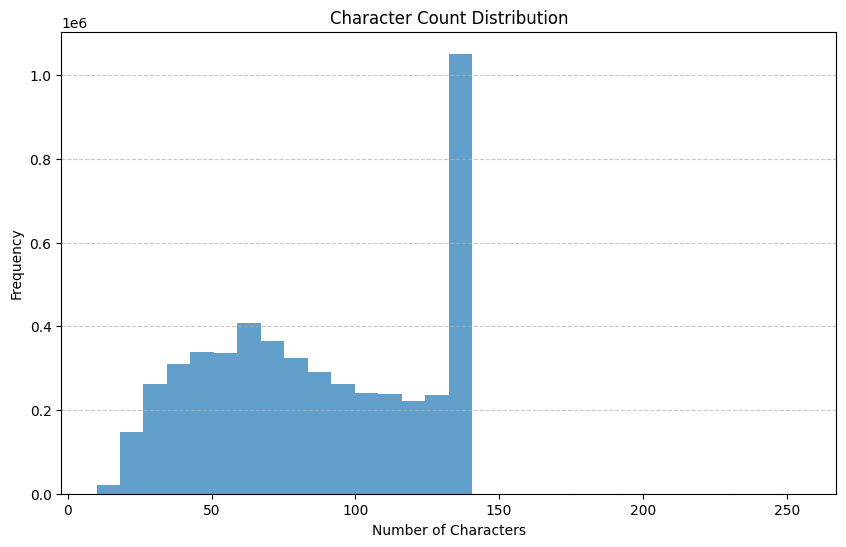

In [28]:
# Analyze tweets: number of characters, language, and hashtags
df['Character_Count'] = df['Tweet'].apply(len)
# Plot histogram of character counts
plt.figure(figsize=(10, 6))
df['Character_Count'].plot(kind='hist', bins=30, alpha=0.7)
plt.title("Character Count Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


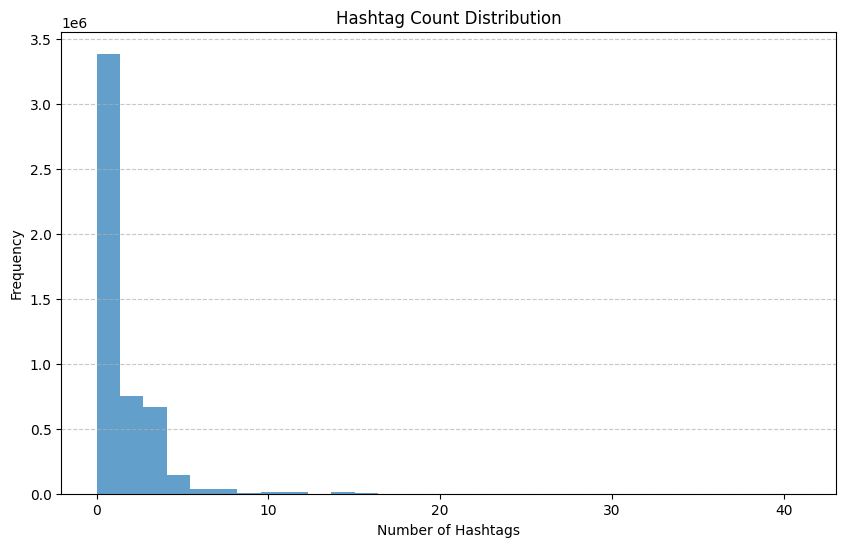

In [29]:
df['Hashtag_Count'] = df['Tweet'].apply(lambda x: x.count('#'))
# Plot histogram of hashtag counts
plt.figure(figsize=(10, 6))
df['Hashtag_Count'].plot(kind='hist', bins=30, alpha=0.7)
plt.title("Hashtag Count Distribution")
plt.xlabel("Number of Hashtags")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

         Hashtag   Count
33           GER  626177
9       WorldCup  566067
21           BRA  279361
75           ARG  265443
5            FRA  216471
25      worldcup  202013
16           MEX  185310
11           NED  174656
17  WorldCup2014  172499
37           POR  150412


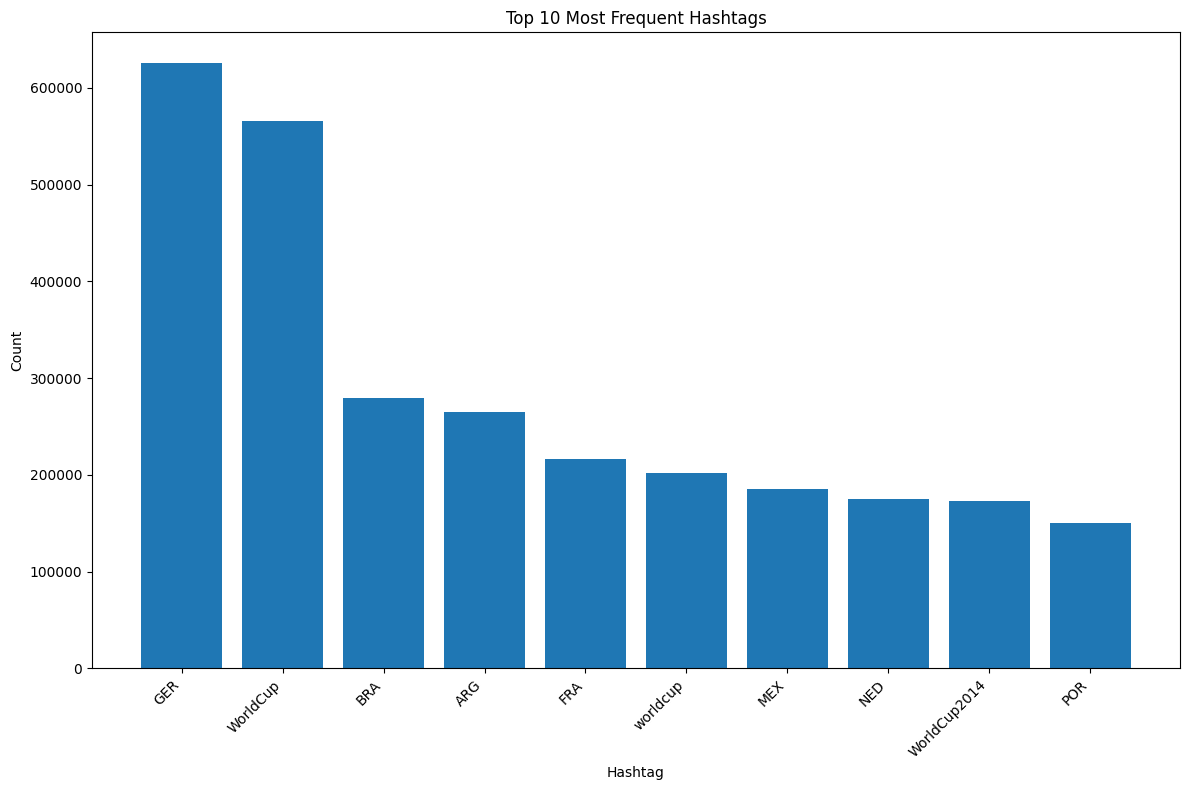

In [46]:

# Function to extract hashtags from a tweet
def extract_hashtags(text):
    return re.findall(r"#(\w+)", text)

# Apply the function to extract hashtags from all tweets
df['Hashtags'] = df['Tweet'].apply(extract_hashtags)

# Flatten the list of lists of hashtags and count occurrences
all_hashtags = [hashtag for hashtags in df['Hashtags'] for hashtag in hashtags]
hashtag_counts = Counter(all_hashtags)

# Convert to a DataFrame for easy analysis
hashtag_df = pd.DataFrame(hashtag_counts.items(), columns=['Hashtag', 'Count']).sort_values(by='Count', ascending=False)

# Display the top 10 most frequent hashtags
top_hashtags = hashtag_df.head(10)
print(top_hashtags)


plt.figure(figsize=(12, 8))
plt.bar(top_hashtags['Hashtag'], top_hashtags['Count'])
plt.title("Top 10 Most Frequent Hashtags")
plt.xlabel("Hashtag")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


(50560, 9)


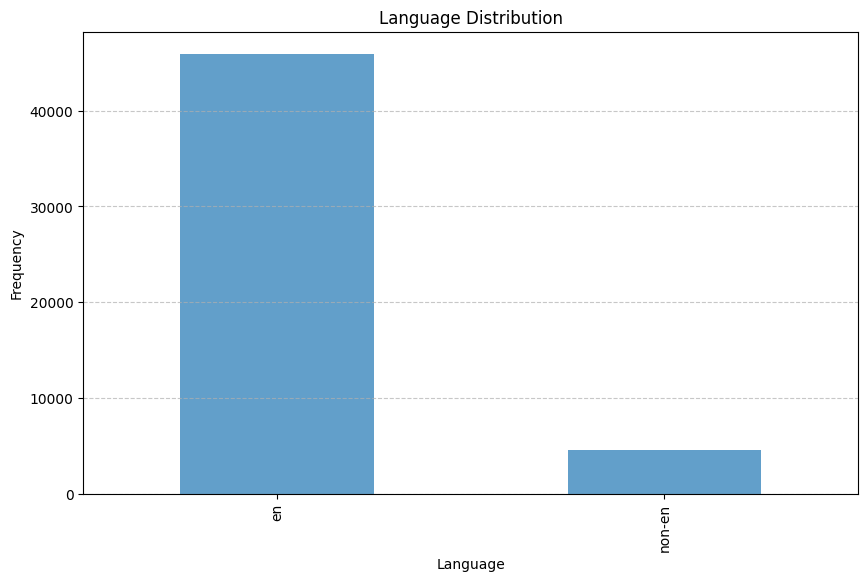

In [34]:
# Sample 10% of the dataset
sampled_df = df.sample(frac=0.01, random_state=42)  # Adjust the random_state for reproducibility
print(sampled_df.shape)

# Function to safely classify a single tweet
def safe_classify(text):
    if text.strip():
        try:
            if classify(text)[0]=='en':
                return 'en'
            else:
                return 'non-en'
        except Exception as e:
            return 'error'  # Return 'error' if classification fails
    else:
        return 'non-en'

# Apply langid to the sampled data
sampled_df['Tweet'] = sampled_df['Tweet'].fillna('').astype(str)
sampled_df['Language'] = sampled_df['Tweet'].apply(safe_classify)

# Plot histogram of language distribution
plt.figure(figsize=(10, 6))
sampled_df['Language'].value_counts().plot(kind='bar', alpha=0.7)
plt.title("Language Distribution")
plt.xlabel("Language")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()